In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = '/users/wanglikun/.local/share/fonts/arial.ttf'  
fm.fontManager.addfont(font_path)                            
arial_name = fm.FontProperties(fname=font_path).get_name()  
plt.rcParams['font.family'] = [arial_name]
plt.rcParams['axes.unicode_minus'] = False

In [2]:
data0 = pd.read_csv("dataset/data.csv", low_memory = False)
data0["label"] = data0["label"].replace({r"\b(PEPH|NaPE)\b": "PE", r"\b(peph)\b": "pe"}, regex = True)
data0["label"] = data0["label"].str.strip()
mask = (data0["label"] == "0") | data0["label"].str.contains("/")
data_nontarget_index, data_target_index = data0.index[mask], data0.index[~mask]
df = data0.loc[data_target_index, :]
df["label"] = df["label"].str.replace(r"\bPE\b","PE/PH",regex=True).str.replace(r"\bpe\b","pe/ph",regex=True)
df = df.reset_index(drop=True)

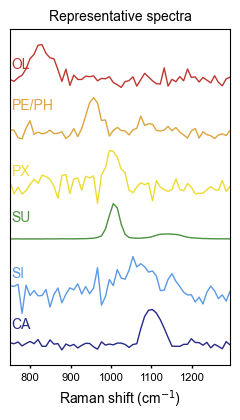

In [3]:
classes = ["OL", "PE/PH", "PX", "SU", "SI", "CA"]
colors = ["#BE3731", "#DDA43D", "#EDDB31", "#4C9140", "#5B99E6", "#262A85"]
spec_cols = df.columns[:-2].astype(float)
df = df.rename(columns=dict(zip(df.columns[:-2], spec_cols)))

targets = [
    {"cls": "OL", "index": 1316},
    {"cls": "PE/PH", "index": 725},
    {"cls": "PX", "index": 1924},
    {"cls": "SU", "index": 2063},
    {"cls": "SI", "index": 203},
    {"cls": "CA", "index": 31},
]

plt.figure(figsize=(2.5, 4.3))
offset_step = 1.5
baseline_offsets = np.arange(len(classes))[::-1] * offset_step
for t, color, offset in zip(targets, colors, baseline_offsets):
    cls = t["cls"]
    idx = t["index"]
    row = df.loc[idx]
    norm_spectrum = row[spec_cols] / row[spec_cols].max()
    plt.plot(norm_spectrum.index, norm_spectrum.values + offset,color=color,linewidth=1)
    x_start = norm_spectrum.index[0]
    y_end = norm_spectrum.values[-1] + offset
    plt.text(x_start + 4,y_end + 0.6,cls,fontsize=10,color=color,va="center")
plt.xlabel("Raman shift (cm$^{-1}$)", fontsize=10)
plt.title("Representative spectra", fontsize=10)
plt.yticks([])
plt.xlim([norm_spectrum.index[0], norm_spectrum.index[56]])
plt.tick_params(axis="both", which="both", width=1, length=2, labelsize=8)
plt.savefig("figure/3a.png", dpi=300, bbox_inches="tight", transparent=True)
plt.tight_layout()
plt.show()


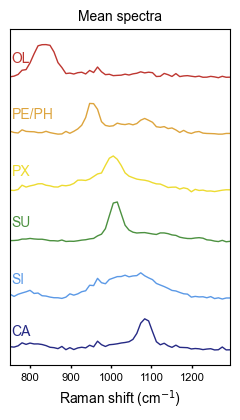

In [4]:
classes = ["OL", "PE/PH", "PX", "SU", "SI", "CA"]
colors = ["#BE3731", "#DDA43D", "#EDDB31", "#4C9140", "#5B99E6", "#262A85"]
spec_cols = df.columns[:-2].astype(float)
df = df.rename(columns=dict(zip(df.columns[:-2], spec_cols)))

plt.figure(figsize=(2.5, 4.3))

offset_step = 1.2   
baseline_offsets = np.arange(len(classes))[::-1] * offset_step

for cls, color, offset in zip(classes, colors, baseline_offsets):
    subset = df[df['label'].str.lower() == cls.lower()]
    norm_spectra = subset[spec_cols].div(subset[spec_cols].max(axis=1), axis=0)
    mean_spectrum = norm_spectra.mean()
    plt.plot(mean_spectrum.index[:57],
             mean_spectrum.values[:57] + offset,
             color=color, linewidth=1)
    x_start = mean_spectrum.index[:57][0]
    y_end = mean_spectrum.values[:57][-1] + offset
    plt.text(x_start + 4, y_end + 0.4, cls, fontsize=10, color=color, va="center")

plt.xlabel("Raman shift (cm$^{-1}$)", fontsize=10)
plt.title("Mean spectra", fontsize=10)

plt.yticks([]) 
plt.xlim([mean_spectrum.index[0], mean_spectrum.index[56]])
plt.tick_params(axis="both", which="both", width=1, length=2, labelsize=8)
plt.savefig("figure/3b.png", dpi=300, bbox_inches="tight", transparent=True)
plt.tight_layout()
plt.show()


In [5]:
import warnings
warnings.filterwarnings("ignore")
from aggmap import AggMap
import seaborn as sns
import numpy as np
np.bool = np.bool_

In [6]:
X = df.iloc[:,:58]
X.columns = X.columns.astype(str)
mp_sar = AggMap(X, metric='euclidean')

2026-01-04 21:45:22,976 - INFO - [bidd-aggmap] - Calculating distance ...
2026-01-04 21:45:22,981 - INFO - [bidd-aggmap] - the number of process is 16


100%|##################################################################################| 58/58 [00:00<00:00, 962.12it/s]


In [8]:
mp_sar = mp_sar.fit(cluster_channels = 7, n_neighbors=15, min_dist=0.1, verbose = 0)
X1 = mp_sar.batch_transform(X.values,scale_method = 'minmax')

2026-01-04 21:45:35,446 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2026-01-04 21:45:35,641 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2026-01-04 21:45:35,649 - INFO - [bidd-aggmap] - Finished


100%|#############################################################################| 2328/2328 [00:00<00:00, 4852.32it/s]


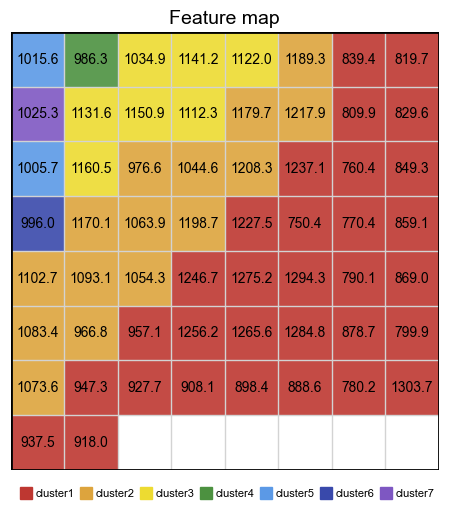

In [9]:
def show_fmap(mp, X, ax):
    mp_colors = {'cluster_01': '#BE3731','cluster_02': '#DDA43D','cluster_03': '#EDDB31',
 'cluster_04': '#4C9140','cluster_05': '#5B99E6','cluster_06': '#3949AB','cluster_07': '#7E57C2'}
    channels = [i for i in mp.colormaps.keys() if i in mp._S.channels]

    for j in channels:
        data = X[:, :, mp._S.channels.index(j)]
        color = mp_colors[j]
        cmap = sns.light_palette(color, n_colors=2, reverse=True)
        sns.heatmap(
            np.where(data != 0, data, np.nan),
            yticklabels=False,
            xticklabels=False,
            cmap=cmap,
            cbar=False,
            ax=ax,            
            alpha=0.9
        )

    feature_names = mp.feature_names_reshape
    feature_names[-6:] = [" "] * 6
    layout = np.array(feature_names).reshape(8, 8)

    H, W = 8, 8
    for r in range(H):
        for c in range(W):
            name = layout[r, c]
            ax.text(
                c + 0.5, r + 0.5, name,  
                ha="center", va="center",
                fontsize=10,
                color="black"
            )
    ax.set_xticks([])
    ax.set_yticks([])

    for x in range(1, W):
        ax.axvline(x=x, color="lightgray", lw=1)
    for y in range(1, H):
        ax.axhline(y=y, color="lightgray", lw=1)   
        
    ax.axhline(y=0, color='black',lw=2, ls =  '-')
    ax.axvline(x=data.shape[1], color='black',lw=2, ls =  '-')
    ax.axhline(y=data.shape[0], color='black',lw=2, ls =  '-')
    ax.axvline(x=0, color='black',lw=2, ls =  '-')   
    
    mp_colors = {'cluster1': '#BE3731','cluster2': '#DDA43D','cluster3': '#EDDB31',
    'cluster4': '#4C9140','cluster5': '#5B99E6','cluster6': '#3949AB','cluster7': '#7E57C2'}      
    channels = ['cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6', 'cluster7']
    ax.legend(
        handles=[plt.plot([], [], marker="s", ms=8, ls="", mec=None, color=mp_colors[ch], label=ch)[0] for ch in channels], 
        bbox_to_anchor=(0.5, -0.02), 
        fontsize=8,
        loc='upper center', 
        ncol=len(channels),    
        facecolor="w", 
        numpoints=1,
        frameon=False,
        handletextpad=-0.1,
        columnspacing=0,
    )
    
fig, ax = plt.subplots(figsize=(5, 5))
X1[0][X1[0] > 0] = 1
show_fmap(mp_sar, X1[0], ax)
plt.tight_layout()
plt.title("Feature map", fontsize=14)
plt.savefig("figure/3c.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

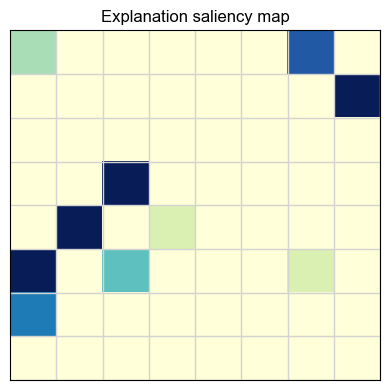

In [10]:
plt.figure(figsize=(4, 4))

pixel_mean = np.load(f"dataset/pixel_loss_SAR_mean.npy")

mean_importance = pixel_mean.mean(axis=0)  
mean_importance_map = mean_importance.reshape(8, 8)

im = plt.imshow(
    mean_importance_map,
    #cmap="rainbow",
    cmap="YlGnBu",
    vmin=0.025,
    vmax=0.035,     
    aspect="auto"
)

plt.title("Explanation saliency map")
plt.xticks([])
plt.yticks([])

for x in range(8):
    plt.axvline(x=x+0.5, color="lightgray", lw=1)
for y in range(8):
    plt.axhline(y=y+0.5, color="lightgray", lw=1)

#plt.colorbar(im, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig(
    "figure/3d.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True
)
plt.show()
